In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 1. 读取数据
df = pd.read_excel('附件2.xlsx')

# 2. 基本信息查看
print("数据维度:", df.shape)
print("原始标签分布:\n", df.iloc[:, -1].value_counts())

# 3. 缺失值检查
print("缺失值统计:\n", df.isnull().sum())


数据维度: (1200, 7)
原始标签分布:
 标签
 1    1091
-1     109
Name: count, dtype: int64
缺失值统计:
 特征一    0
特征二    0
特征三    0
特征四    0
特征五    0
特征六    0
标签     0
dtype: int64


Sizes → train: 720, val: 240, test: 240

=== 5-Fold CV on train+val ===
Fold 1: Acc=0.9948, Prec=1.0000, Rec=0.9412, F1=0.9697
Fold 2: Acc=0.9844, Prec=0.8889, Rec=0.9412, F1=0.9143
Fold 3: Acc=0.9896, Prec=1.0000, Rec=0.8824, F1=0.9375
Fold 4: Acc=0.9896, Prec=1.0000, Rec=0.8889, F1=0.9412
Fold 5: Acc=0.9792, Prec=1.0000, Rec=0.7778, F1=0.8750

CV Summary:
acc = 0.9875 ± 0.0053
prec = 0.9778 ± 0.0444
rec = 0.8863 ± 0.0597
f1 = 0.9275 ± 0.0316

=== Final Evaluation on TEST set ===

Test Metrics:
 Accuracy : 0.9875
 Precision: 0.9524
 Recall   : 0.9091
 F1 Score : 0.9302

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       218
     Anomaly       0.95      0.91      0.93        22

    accuracy                           0.99       240
   macro avg       0.97      0.95      0.96       240
weighted avg       0.99      0.99      0.99       240



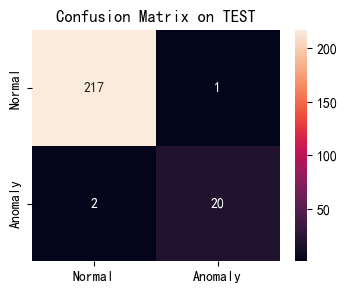

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 读数据 & 映射标签
df = pd.read_excel('附件2.xlsx')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].map({1:0, -1:1}).values  # 1→0 正常, -1→1 异常

# 2. 标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. 原始 split：60% train 20% val 20% test
X_tvl, X_test, y_tvl, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tvl, y_tvl, test_size=0.25, stratify=y_tvl, random_state=42
)
print(f"Sizes → train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

# 4. 定义 DataLoader 构造函数
def make_loader(X_arr, y_arr, batch_size=32, shuffle=True):
    tx = torch.from_numpy(X_arr).float().to(device)
    ty = torch.from_numpy(y_arr).long().to(device)
    return DataLoader(TensorDataset(tx, ty), batch_size=batch_size, shuffle=shuffle)

# 5. MLP 分类器
class MLPClassifier(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim,16), nn.ReLU(), nn.BatchNorm1d(16), nn.Dropout(0.3),
            nn.Linear(16,8),  nn.ReLU(), nn.BatchNorm1d(8),  nn.Dropout(0.3),
            nn.Linear(8,2)
        )
    def forward(self, x): return self.net(x)

# 6. 在 train+val 上做 5 折 CV
print("\n=== 5-Fold CV on train+val ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_metrics = {'acc':[], 'prec':[], 'rec':[], 'f1':[]}

for fold, (tr_idx, vl_idx) in enumerate(skf.split(X_tvl, y_tvl), 1):
    X_tr, X_vl = X_tvl[tr_idx], X_tvl[vl_idx]
    y_tr, y_vl = y_tvl[tr_idx], y_tvl[vl_idx]

    tr_loader = make_loader(X_tr, y_tr, shuffle=True)
    vl_loader = make_loader(X_vl, y_vl, shuffle=False)

    model = MLPClassifier(dim=X.shape[1]).to(device)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    # 简单训练 20 epochs
    for ep in range(20):
        model.train()
        for xb, yb in tr_loader:
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()

    # 验证
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for xb, yb in vl_loader:
            logits = model(xb)
            preds.append(logits.argmax(1).cpu().numpy())
            truths.append(yb.cpu().numpy())
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(truths)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    for k,v in zip(cv_metrics, (acc,prec,rec,f1)):
        cv_metrics[k].append(v)

# CV 汇总
print("\nCV Summary:")
for k, vals in cv_metrics.items():
    print(f"{k} = {np.mean(vals):.4f} ± {np.std(vals):.4f}")

# 7. 最终模型：用全部 train+val 重新训练，并在 test 上评估
print("\n=== Final Evaluation on TEST set ===")
full_loader = make_loader(X_tvl, y_tvl, shuffle=True)
test_loader = make_loader(X_test, y_test, shuffle=False)

model = MLPClassifier(dim=X.shape[1]).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# 训练 30 epochs
for ep in range(30):
    model.train()
    for xb, yb in full_loader:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# Test 评估
model.eval()
preds, truths = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        truths.append(yb.cpu().numpy())
yt = np.concatenate(truths)
pt = np.concatenate(preds)

print("\nTest Metrics:")
print(f" Accuracy : {accuracy_score(yt, pt):.4f}")
print(f" Precision: {precision_score(yt, pt, zero_division=0):.4f}")
print(f" Recall   : {recall_score(yt, pt, zero_division=0):.4f}")
print(f" F1 Score : {f1_score(yt, pt, zero_division=0):.4f}")
print("\n" + classification_report(
    yt, pt, target_names=['Normal','Anomaly'], zero_division=0
))

# 混淆矩阵
cm = confusion_matrix(yt, pt, labels=[0,1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Normal','Anomaly'],
            yticklabels=['Normal','Anomaly'])
plt.title('Confusion Matrix on TEST')
plt.show()
